In [3]:
import sys
sys.path.insert(1, '../')
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error

from agingml import temporal_degradation_test as tdt

/Users/santiago/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def plot_results():
    for model in models:
        errors_df = pd.read_parquet(f'../results/aging/{dataset}/aging_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod.parquet')
        d_errors_df = pd.read_parquet(f'../results/aging/{dataset}/aging_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod_{freq}.parquet')
        
        errors_df = errors_df[errors_df['model_age'] <= 80]
        d_errors_df = d_errors_df[d_errors_df['model_age'] <= 80]
        test_errors_df = errors_df[errors_df['partition'] == 'test']
        test_mape = test_errors_df.groupby('simulation_id').apply(lambda group: mean_absolute_percentage_error(group.y, group.y_pred))
        test_mape = pd.DataFrame(test_mape, columns=['test_mape']).reset_index()

        d_errors_df = pd.merge(d_errors_df, test_mape, how='left', on='simulation_id')
        d_errors_df = d_errors_df[d_errors_df['test_mape'] <= 0.1]

        valid_models = len(d_errors_df['simulation_id'].drop_duplicates())
        print(f'There are {valid_models} out of {n_simulations}')

        fig = tdt.plot_aging_chart(d_errors_df, metric='MAPE', freq='weeks', plot_name=f"Model Aging Chart: US Avocado Hass Dataset - {model}")
        fig.show()
        fig.savefig(f'../figures/aging_plot_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod.svg', format='svg')

There are 884 out of 1000


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_2745/1370563447.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


There are 842 out of 1000


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_2745/1370563447.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


There are 860 out of 1000


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_2745/1370563447.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


There are 625 out of 1000


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_2745/1370563447.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


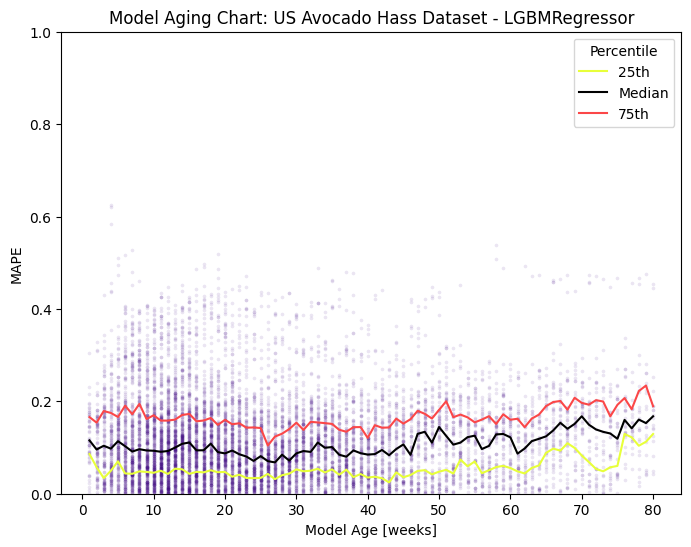

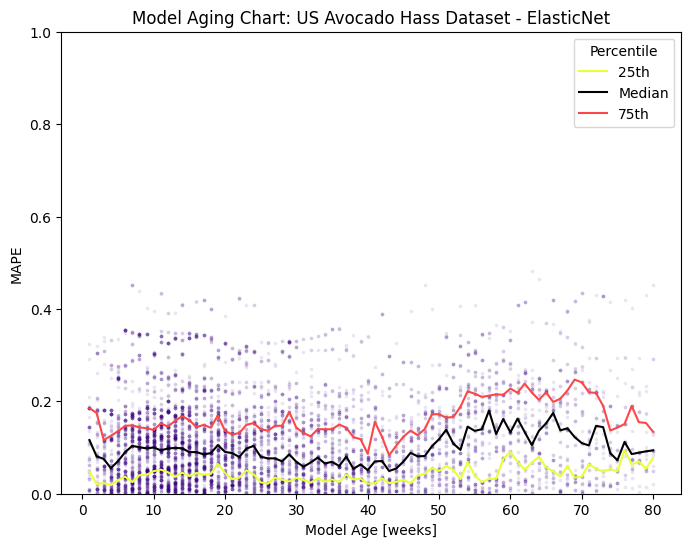

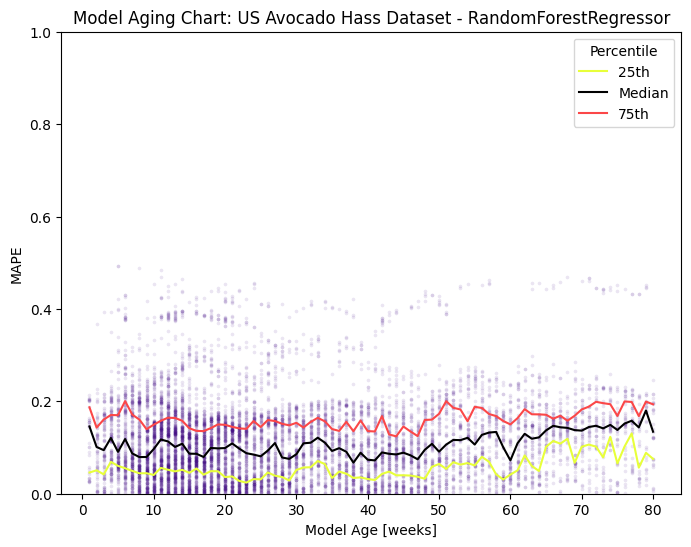

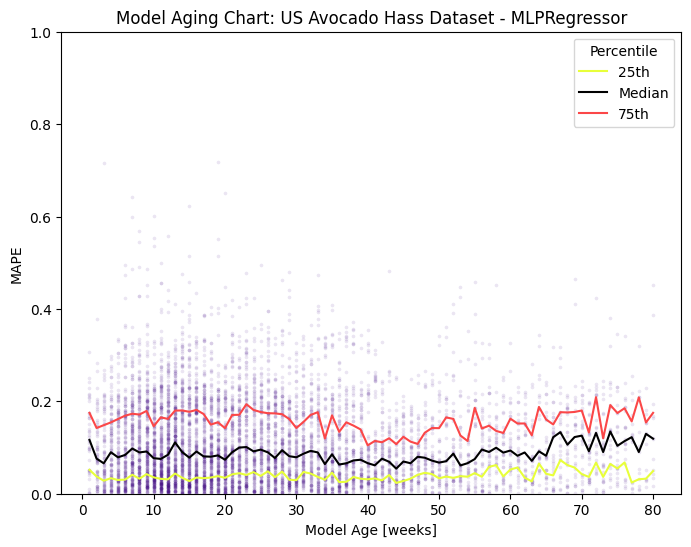

In [5]:
n_simulations = 1000
n_prod = 12
dataset = 'avocados'
freq='W'
models =['LGBMRegressor', 'ElasticNet', 'RandomForestRegressor', 'MLPRegressor']
plot_results()

There are 2684 out of 3000


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_2745/1370563447.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


There are 2423 out of 3000


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_2745/1370563447.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


There are 2675 out of 3000


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_2745/1370563447.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


There are 2045 out of 3000


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_2745/1370563447.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


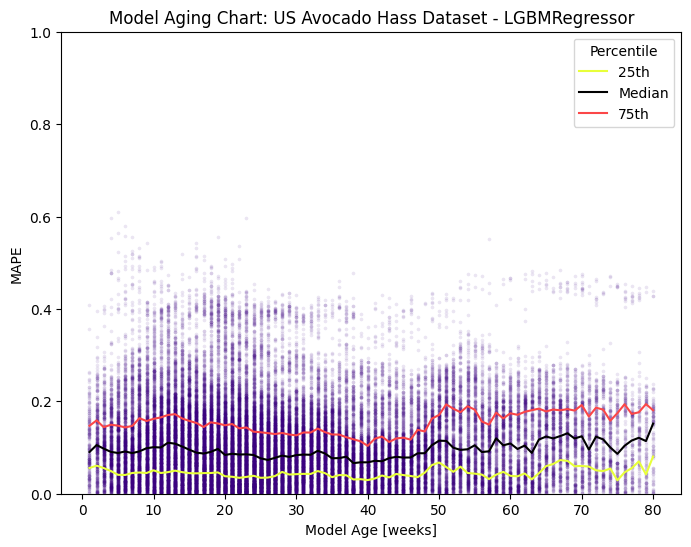

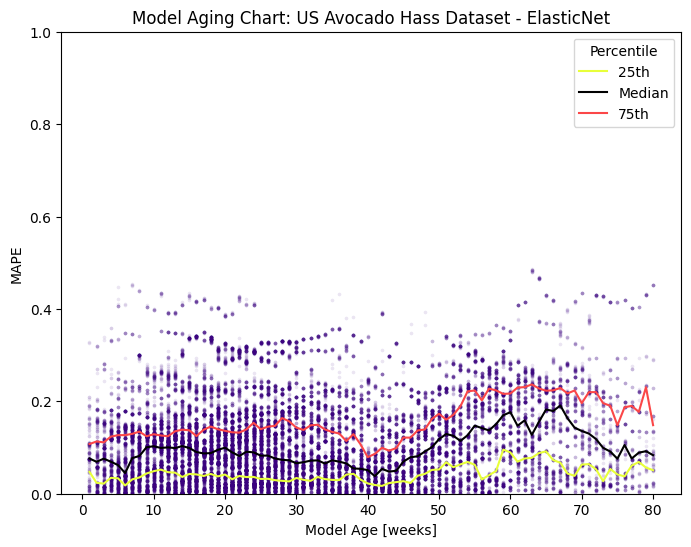

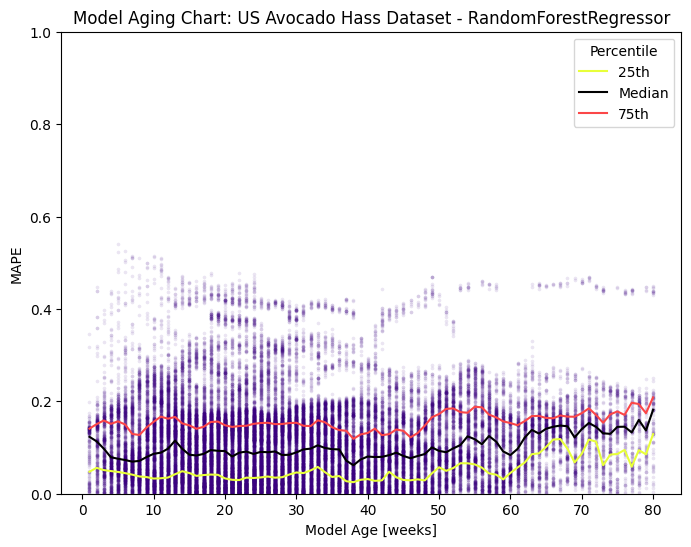

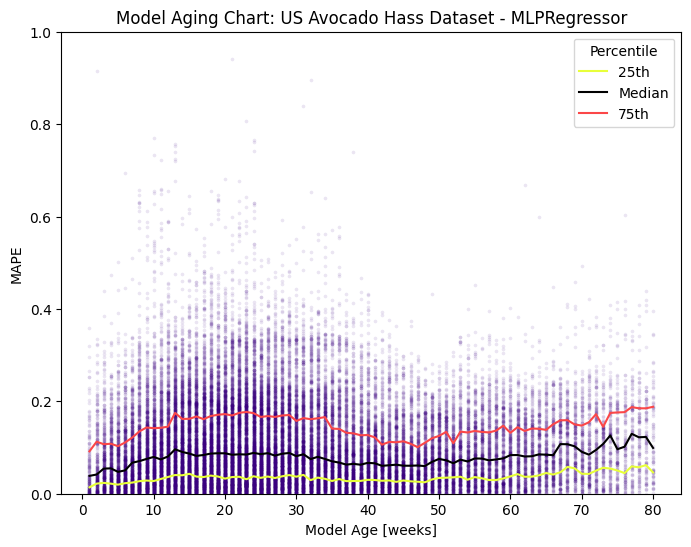

In [6]:
n_simulations = 3000
n_prod = 24
dataset = 'avocados'
freq='W'
models =['LGBMRegressor', 'ElasticNet', 'RandomForestRegressor', 'MLPRegressor']
plot_results()

In [9]:
freq = 'M'
metric = mean_absolute_percentage_error

for model in models:
    errors_df = pd.read_parquet(f'../results/aging/{dataset}/aging_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod.parquet')
    d_errors_df = tdt.aggregate_errors_data(errors_df, metric=metric, freq=freq, only_valid_models=True)
    d_errors_df.to_parquet(f'../results/aging/{dataset}/aging_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod_{freq}.parquet')

In [41]:
freq = 'M'
d_errors_df = pd.read_parquet(f'../results/aging/{dataset}/aging_{dataset}_{models[0]}_{n_simulations}_simulations_{n_prod}_prod_{freq}.parquet')

In [42]:
d_errors_df

,partition,simulation_id,timestamp,error,last_val_date,model_age,is_model_valid,error_rel
0,train,0,2015-06-30,0.030116,2016-09-30,-15.047537,True,0.671673
1,train,0,2015-07-31,0.023567,2016-09-30,-14.029036,True,0.525630
2,train,0,2015-08-31,0.023581,2016-09-30,-13.010534,True,0.525925
3,train,0,2015-09-30,0.034685,2016-09-30,-12.024888,True,0.773597
4,train,0,2015-10-31,0.031170,2016-09-30,-11.006386,True,0.695196
...,...,...,...,...,...,...,...,...
98625,prod,2999,2016-12-31,0.064920,2016-08-31,4.008296,True,1.447913
98626,prod,2999,2017-01-31,0.211803,2016-08-31,5.026797,True,4.723880
98627,prod,2999,2017-02-28,0.061629,2016-08-31,5.946734,True,1.374530
98628,prod,2999,2017-03-31,0.094707,2016-08-31,6.965235,True,2.112275


In [57]:
data = d_errors_df[d_errors_df['partition'] == 'prod']
data.model_age = round(data.model_age).astype(int)
data = data[(data['model_age'] >= 0) & (data['model_age'] <= 20)]


/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_2745/1444763648.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.model_age = round(data.model_age).astype(int)


Text(0.5, 1.0, 't')

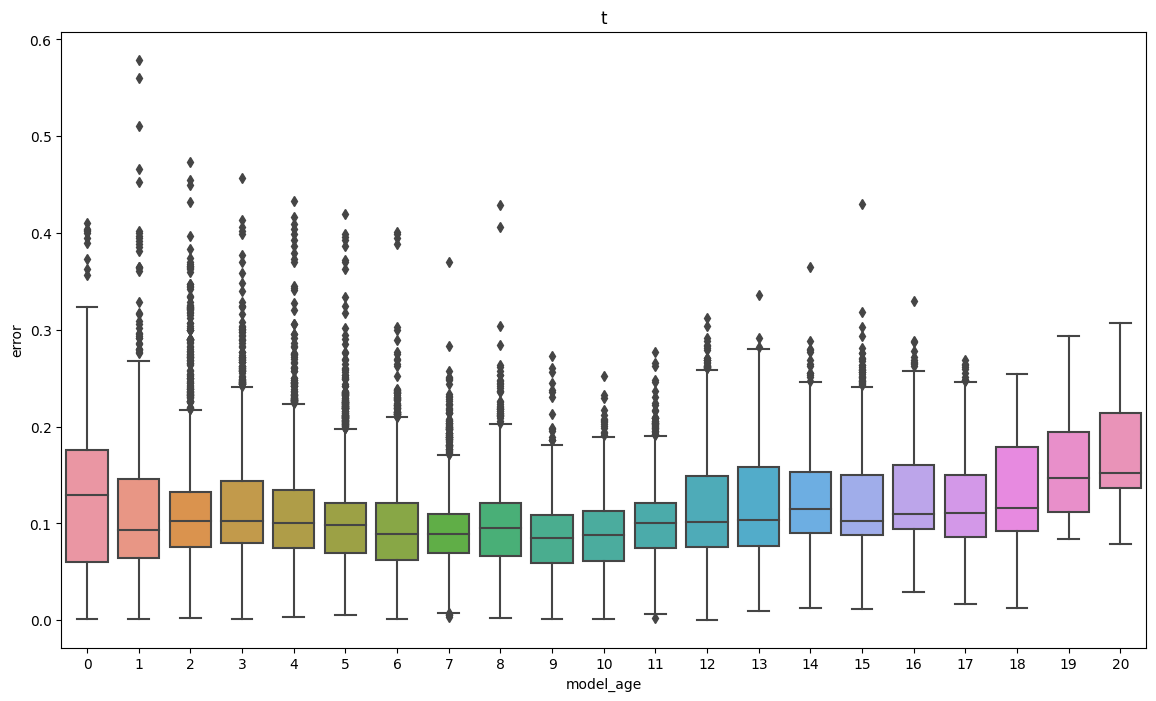

In [61]:
for model in models:
    data = d_errors_df[d_errors_df['partition'] == 'prod']
    data.model_age = round(data.model_age).astype(int)
    data = data[(data['model_age'] >= 0) & (data['model_age'] <= 20)]

fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=data, x="model_age", y="error", ax=ax)
ax.set_title('Weekly error distribution: US Avocado Hass Dataset - Model')